# News Aggregation & Categorisation Notebook

This notebook automatically fetches Hong Kong news articles from multiple sources, then uses **semantic similarity search** to categorise them into predefined topics (e.g. Housing, Medical, Property).

## How It Works

1. **Load labelled training data** — positive and negative example articles per category (`NewsDataSave.csv`)
2. **Generate embedding vectors** — using the [BGE-m3](https://huggingface.co/BAAI/bge-m3) multilingual model via HuggingFace
3. **Fetch today's news** from three sources: Mingpao (明報), Oriental Daily (東方日報), HK Government Press Releases (新聞公報)
4. **Build FAISS vector indexes** for each source and search using category query vectors
5. **Export matched results** to a timestamped CSV file

## Prerequisites

- **Python 3.13+** with dependencies from `requirements.txt`
- **CUDA-capable GPU** — required for the embedding model
- **Internet access** — to fetch live RSS feeds and scrape news sites

## Configuration

Key parameters can be adjusted in the `CONFIG` dictionary in the first code cell:

| Parameter | Default | Description |
|-----------|---------|-------------|
| `score_threshold` | 0.7 | Maximum squared L2 distance to include a result (lower distance = higher cosine similarity; 0.7 corresponds to cosine similarity ≥ 0.65) |
| `search_k` | 15 | Number of results to retrieve per category query |
| `request_delay` | 0.5s | Delay between HTTP requests (rate limiting) |
| `request_timeout` | 10s | HTTP request timeout |
| `max_retries` | 3 | Retry attempts for failed HTTP requests |

In [1]:
# Imports and setup

import numpy as np
import pandas as pd
import feedparser
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from bs4 import BeautifulSoup
from datetime import datetime, timedelta, timezone
from dateutil import parser
import time
from tqdm import tqdm
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_core.documents import Document as LangchainDocument

# Configuration
CONFIG = {
    "score_threshold": 0.7,  # Max squared L2 distance (lower = more similar; 0.7 ≈ cosine similarity >= 0.65)
    "search_k": 15,
    "request_delay": 0.5,  # seconds between requests for rate limiting
    "request_timeout": 10,  # seconds
    "max_retries": 3,
}

# HTTP headers for web scraping
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

# Hong Kong timezone
HK_TZ = timezone(timedelta(hours=8))

# Setup session with retry logic
def create_session():
    session = requests.Session()
    retry_strategy = Retry(
        total=CONFIG["max_retries"],
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

session = create_session()

# 1. Initialise Embedding Model

We use [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3), a multilingual embedding model that supports Chinese and English text. Embeddings are **L2-normalised** (`normalize_embeddings=True`) so that for unit vectors: $\|\vec{a} - \vec{b}\|^2 = 2(1 - \cos(\vec{a}, \vec{b}))$.

We use `DistanceStrategy.EUCLIDEAN_DISTANCE` (i.e. `IndexFlatL2`) explicitly. LangChain's `DistanceStrategy.COSINE` also creates `IndexFlatL2` under the hood — there is no true cosine similarity index in LangChain FAISS. Since our embeddings are already L2-normalised, squared L2 distance is equivalent to cosine distance: lower values indicate higher cosine similarity.

In [2]:
# Initialize embeddings model (HuggingFace BGE)
import torch

model_name = "BAAI/bge-m3"
model_kwargs = {'device': 'cuda'} # 'torch_dtype': torch.float16 to use FP16 (optional, halves model memory from ~2.2GB to ~1.1GB
encode_kwargs = {'normalize_embeddings': True, 'batch_size': 8} # L2-normalise so that squared L2 distance = 2*(1 - cosine_similarity)
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


## Helper: `search_by_category()`

This function performs similarity search against a FAISS index for each news category. The **category query vector** is computed as:

$$\vec{q} = \text{norm}\left(\sum \vec{v}_{\text{positive}} - \sum \vec{v}_{\text{negative}}\right)$$

where positive/negative vectors come from the labelled training data. Results with squared L2 distance **below** the configured `score_threshold` are returned (lower distance = higher cosine similarity = better match).

In [3]:
# Helper function for similarity search across a FAISS database

def search_by_category(db, ev_cat, categories, source_name):
    """
    Perform similarity search for all categories against a FAISS database.
    
    Args:
        db: FAISS vector store
        ev_cat: Dictionary of category embeddings {category: [[positive], [negative]]}
        categories: List of category names to search
        source_name: Name of the news source for display
    
    Returns:
        List of results as dicts with category, score (squared L2 distance), title, source, newspaper.
        Lower scores indicate stronger matches.
    """
    results = []
    
    for cat in categories:
        ev_pos = np.sum(ev_cat[cat][0], axis=0)
        ev_neg = np.sum(ev_cat[cat][1], axis=0) if ev_cat[cat][1] else 0
        ev = ev_pos - ev_neg
        ev = ev / np.linalg.norm(ev)
        
        # score_threshold is max squared L2 distance; lower distance = better match
        matches = db.similarity_search_with_score_by_vector(
            ev, 
            k=CONFIG["search_k"], 
            score_threshold=CONFIG["score_threshold"]
        )
        
        for item in matches:
            results.append({
                "category": cat,
                "score": float(item[1]),
                "title": item[0].metadata["title"],
                "source": item[0].metadata["source"],
                "newspaper": item[0].metadata["newspaper"]
            })
            print(f"{item[1]:.4f}: {item[0].metadata['title']} {item[0].metadata['source']}")
        
        if not matches:
            print(f"  (no matches within threshold)")
    
    return results

# 2. Load Labelled Training Data

The file `NewsDataSave.csv` contains manually labelled news articles used to build category query vectors. Each row has:

- **Categories** — the topic label (e.g. Elderly, Housing, Property)
- **Titles** / **Summary** — the article text used for embedding
- **Negative** — `0` for positive examples (articles that belong to the category), `1` for negative examples (articles that should be excluded)

The positive and negative embeddings are combined to create a query vector that captures what each category *is* and *is not*.

In [4]:
# Load labeled news data for training embedding vectors
mdata = pd.read_csv('NewsDataSave.csv', na_filter=False)

# Dictionary to store embeddings by category
ev_cat = {}

# Generate embedding vectors for each category based on labeled data
for cat in mdata.Categories.unique():

    print(cat)

    ev_list = []

    for neg_sample in [0, 1]:

        if neg_sample == 0:
            print("Positive Sample:")
        else:
            print("Negative Sample:")

        sample_list = []
        subset = mdata[(mdata.Categories == cat) & (mdata.Negative == neg_sample)]

        for _, row in subset.iterrows():

            if row['Summary'] == "":
                raise ValueError("No text summary!")

            text = row['Titles'] + ' ' + row['Summary']

            # Create embeddings using title and content
            sample_list.append(embeddings.embed_query(text))
            print(text)

        ev_list.append(sample_list)

    ev_cat[cat] = ev_list

Elderly
Positive Sample:
以老護老悲劇多　申訴專員公署全面調查照顧者暫託服務｜即時新聞｜港澳｜on.cc東網 申訴專員陳積志今日（９日）宣布，該署將主動調查政府支援長者及殘疾人士照顧者的暫託服務。他指近年本港不時發生照顧者疑因不堪壓力而導致倫常慘案，而「以老護老」、「以老護殘」、「以殘護殘」的失救悲劇時有發生。他指出，照顧者日常生活所面對的困難及承受的巨大壓力，是「老大難」的民生問題。公署留意到，現屆政府已落實多項以照顧者為本的針對性支援措施，包括擴展暫託服務網絡及推出照顧者支援專線等。但政府的數據顯示相關暫託服務可能未被充分使用，且有意見認為暫託服務供應地區分布不均、申請程序繁複及欠缺配套等。陳積志表示：「希望透過這項主動調查行動，認真審視有否進一步提升及改善相關措施的空間，更好地為照顧者分憂解難、改善生活質素。」調查包括審研現有長者及殘疾人士暫託服務的運作安排，包括服務規劃、申請流程、提供予照顧者的配套及資訊、服務質素及使用率的監察，以及服務推廣及宣傳工作等，並在有需要時提出適切的改善建議。[申訴專員公署會主動調查政府支援長者及殘疾人士照顧者的暫託服務情況。]申訴專員公署會主動調查政府支援長者及殘疾人士照顧者的暫託服務情況。
綜援及公共福利金明年2月上調1.3%　財政承擔增逾9億元｜即時新聞｜中港台｜on.cc東網 明年2月1日起把綜援和公共福利金計劃津貼金額上調1.3%。立法會財務委員會今日(6日)通過，明年2月1日起把綜合社會保障援助計劃標準項目金額和公共福利金計劃津貼金額上調1.3%，由此而來會增加9億2,700萬港元財政承擔，受惠人數約160萬。不少議員都質疑，政府打算要求健全的失業綜援受助人參加無償工作的計劃，對脫離綜援網有多大幫助，此外又關注計劃的行政支出。政府代表直言，未知計劃可減省多少綜緩開支，但預計有將1萬人參加無償工作，冀長遠可減少綜援方面的支出。政府計劃於明年10月試行為期兩年的「失業受助人士支援計劃」，要求15至59歲的失業健全綜援受助人士，每周參與無償工作至少1小時，否則會扣減綜援。議員林振昇指出，無償工作沒有僱傭關係和最低工資，談不上正式的工作，對於受助人將來能找一份正式的工作，以脫離綜援網的作用到底有多大？他關注政府會否加大就業支援，建議大企業給受助人工作機會，或給予照顧者一些彈性工作安排，讓他們投入職場，脫

# 3. Fetch News from Sources

We fetch today's articles from three Hong Kong news sources. Each source is processed independently: fetch articles, convert to LangChain documents (combining title + content), build a FAISS index, then search.

| Source | Method | Filter |
|--------|--------|--------|
| 明報 (Mingpao) | RSS feeds (18 sections) | Today's articles only |
| 東方日報 (Oriental Daily) | Web scraping via sitemap | Today's sitemap page |
| 新聞公報 (HK Gov) | RSS feed | Last 24 hours |

## 3a. Mingpao (明報)

Mingpao provides RSS feeds for each news section. We aggregate entries from all sections, filter to today's date, then embed each article's title + summary.

### Fetch RSS feeds

Parse all Mingpao RSS feeds and combine the entries into a single list. Feeds with parsing errors are skipped with a warning.

In [5]:
# List of RSS feed URLs from Mingpao
rss_list = ["https://news.mingpao.com/rss/pns/s00001.xml", #要聞
            "https://news.mingpao.com/rss/pns/s00002.xml", #港聞
            "https://news.mingpao.com/rss/pns/s00003.xml", #社評
            "https://news.mingpao.com/rss/pns/s00004.xml", #經濟
            "https://news.mingpao.com/rss/pns/s00005.xml", #副刊
            "https://news.mingpao.com/rss/pns/s00011.xml", #教育
            "https://news.mingpao.com/rss/pns/s00012.xml", #觀點
            "https://news.mingpao.com/rss/pns/s00013.xml", #中國
            "https://news.mingpao.com/rss/pns/s00014.xml", #國際
            "https://news.mingpao.com/rss/pns/s00015.xml", #體育
            "https://news.mingpao.com/rss/pns/s00016.xml", #娛樂
            "https://news.mingpao.com/rss/pns/s00017.xml", #英文
            "https://news.mingpao.com/rss/pns/s00018.xml" #作家專欄
            ]

# Parse all RSS feeds and aggregate entries
feed_list = []
for rss in rss_list:
    response = session.get(rss, headers=HEADERS, timeout=CONFIG["request_timeout"])
    response.encoding = 'utf-8'
    feed = feedparser.parse(response.text)
    if feed.bozo and not feed.entries:
        print(f"Warning: Error parsing {rss}: {feed.bozo_exception}")
        continue
    feed_list += feed.entries

print(f"Total entries from RSS feeds: {len(feed_list)}")

Total entries from RSS feeds: 436


### Filter to today's news

Only keep articles published on or after midnight today (HK time).

In [6]:
# Handle dates/times for news

today = datetime.now(HK_TZ)
print("Today's date:", today.date())
today_start = today.replace(hour=0, minute=0, second=0, microsecond=0).astimezone(timezone.utc)

feed_list = [feed for feed in feed_list if parser.parse(feed.published) >= today_start]

print('No. of news:', len(feed_list))

Today's date: 2026-02-25
No. of news: 134


### Convert to documents and build FAISS index

Each RSS entry is converted to a LangChain `Document` with `page_content = title + summary` and metadata (source URL, title, newspaper name). These documents are then embedded and stored in a FAISS vector index using `IndexFlatL2`. Since embeddings are L2-normalised, the returned squared L2 distances are equivalent to cosine distances: $\|\vec{a} - \vec{b}\|^2 = 2(1 - \cos(\vec{a}, \vec{b}))$. Lower scores = better matches.

In [7]:
# Processing step

documents = []
for entry in feed_list:
    content = entry.title + " " + entry.summary
    metadata = {
        "source": "/".join(entry.link.split("/")[:-1]),
        "title": entry.title,
        "newspaper": "明報"
    }
    documents.append(LangchainDocument(page_content=content, metadata=metadata))

In [8]:
# Create FAISS vector store using explicit L2 distance
# Note: DistanceStrategy.COSINE also uses IndexFlatL2 internally — no real cosine similarity index exists in LangChain FAISS.
# With L2-normalised embeddings, squared L2 distance = 2*(1 - cosine_similarity), so lower = better.

if documents:
    db = FAISS.from_documents(documents, embeddings, distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE)
    print(f"FAISS index created with {len(documents)} documents — distance strategy: {db.distance_strategy}")
else:
    db = None
    print("No Mingpao documents to index — skipping FAISS creation")

FAISS index created with 134 documents — distance strategy: DistanceStrategy.EUCLIDEAN_DISTANCE


### Search Mingpao by category

Run similarity search for each topic category against the Mingpao FAISS index. Articles with squared L2 distance below the threshold are printed and collected (lower score = stronger match).

In [9]:
# Search Mingpao news by category

print("=== Mingpao (明報) ===")
categories = mdata.Categories.unique()
mingpao_results = []

if db is not None:
    for cat in categories:
        print(f"{cat}")
        mingpao_results.extend(search_by_category(db, ev_cat, [cat], "明報"))
else:
    print("No Mingpao index available — skipping search")

=== Mingpao (明報) ===
Elderly
  (no matches within threshold)
Housing
0.6564: 嶺大研究：26%父母願助子女置業 https://news.mingpao.com/pns/%e6%b8%af%e8%81%9e/article/20260225/s00002/1771952869946
Land Development
0.6865: 聞風筆動：政府冀一勞永逸 宏志閣收購門檻未有定論  ／文：李先知 https://news.mingpao.com/pns/%e8%a7%80%e9%bb%9e/article/20260225/s00012/1771952874746
Link REIT
  (no matches within threshold)
Medical
  (no matches within threshold)
Pension
  (no matches within threshold)
Property
0.6291: 黎永滔逾億沽中環商住樓 帳賺近五成 https://news.mingpao.com/pns/%e7%b6%93%e6%bf%9f/article/20260225/s00004/1771952884692
0.6477: CAPRI洋房3500萬沽 業主料輸五成 https://news.mingpao.com/pns/%e7%b6%93%e6%bf%9f/article/20260225/s00004/1771952884465
0.6726: 匯豐1個月港元定存年利率10厘 https://news.mingpao.com/pns/%e7%b6%93%e6%bf%9f/article/20260225/s00004/1771952882184
0.6882: 美聯黃建業：今年樓價可升逾10% https://news.mingpao.com/pns/%e7%b6%93%e6%bf%9f/article/20260225/s00004/1771952884582
Public Finance
0.5210: 羅崑：「十五五」開局年：香港財政突圍戰略 https://news.mingpao.com/pns/%e8%a7%80%e9%bb%9e/artic

## 3b. Oriental Daily (東方日報)

Oriental Daily does not provide RSS feeds, so we scrape their daily sitemap page and then fetch the first 2 paragraphs of each article. Rate limiting (`request_delay`) is applied between requests.

### Fetch today's sitemap

Scrape the daily sitemap page to get a list of all article links for today.

In [10]:
# Fetch and parse feeds/articles

today = datetime.now(HK_TZ)

url = r'https://orientaldaily.on.cc/section/sitemap/' + today.date().strftime('%Y%m%d')

response = session.get(url, headers=HEADERS, timeout=CONFIG["request_timeout"])

soup = BeautifulSoup(response.text, 'html.parser')

items = soup.find_all('li', attrs={'class': 'item'})
print(f"Found {len(items)} articles to scrape")

Found 205 articles to scrape


### Scrape article content

Visit each article page and extract the first 2 paragraphs as the article summary. Failed requests are logged and skipped.

In [11]:
# Fetch and parse feeds/articles

on_list = []

for item in tqdm(items, desc="Scraping Oriental Daily"):
    title = item.text
    link = r'https://orientaldaily.on.cc' + item.find('a')['href']

    try:
        response = session.get(link, headers=HEADERS, timeout=CONFIG["request_timeout"])
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Failed to fetch {link}: {e}")
        continue

    soup = BeautifulSoup(response.text, 'html.parser')
    paras = soup.find_all('div', class_='paragraph')

    content = ''
    for i, p in enumerate(paras):
        if i >= 2:
            break
        content += p.get_text()

    content = ''.join(content.split())

    on_list.append([title, link, content])

    # Rate limiting
    time.sleep(CONFIG["request_delay"])

Scraping Oriental Daily: 100%|██████████| 205/205 [02:17<00:00,  1.49it/s]


In [12]:
# Processing step

print('No. of news:', len(on_list))

No. of news: 205


### Convert to documents, build FAISS index, and search

Same pipeline as Mingpao: create LangChain documents, build a FAISS index, then search by category.

In [13]:
# Processing step

on_documents = []
for entry in on_list:
    content = entry[0] + ' ' + entry[2]
    metadata = {
        "source": "/".join(entry[1].split("/")[:-1]) + "/",
        "title": entry[0],
        "newspaper": "東方日報"
    }
    on_documents.append(LangchainDocument(page_content=content, metadata=metadata))

In [14]:
# Create FAISS vector store using explicit L2 distance
# Note: DistanceStrategy.COSINE also uses IndexFlatL2 internally — no real cosine similarity index exists in LangChain FAISS.
# With L2-normalised embeddings, squared L2 distance = 2*(1 - cosine_similarity), so lower = better.

if on_documents:
    on_db = FAISS.from_documents(on_documents, embeddings, distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE)
    print(f"FAISS index created with {len(on_documents)} documents — distance strategy: {on_db.distance_strategy}")
else:
    on_db = None
    print("No Oriental Daily documents to index — skipping FAISS creation")

FAISS index created with 205 documents — distance strategy: DistanceStrategy.EUCLIDEAN_DISTANCE


In [15]:
# Search Oriental Daily news by category

print("=== Oriental Daily (東方日報) ===")
oriental_results = []

if on_db is not None:
    for cat in categories:
        print(f"{cat}")
        oriental_results.extend(search_by_category(on_db, ev_cat, [cat], "東方日報"))
else:
    print("No Oriental Daily index available — skipping search")

=== Oriental Daily (東方日報) ===
Elderly
0.5527: 醫健：健康在您手：護老者的喘息空間 https://orientaldaily.on.cc/content/要聞港聞/odn-20260225-0225_00176_226/
Housing
0.6909: 龍七公：大埔災民安置  應兼備情理法 https://orientaldaily.on.cc/content/要聞港聞/odn-20260225-0225_00184_008/
Land Development
0.6351: 宏福苑安置改口風 長遠研立法強制行動 https://orientaldaily.on.cc/content/要聞港聞/odn-20260225-0225_00176_021/
Link REIT
  (no matches within threshold)
Medical
  (no matches within threshold)
Pension
  (no matches within threshold)
Property
0.5647: 資助房屋按揭  按月飆逾4倍 https://orientaldaily.on.cc/content/產經/odn-20260225-0225_00204_071/
0.5800: 地產速報一覽 https://orientaldaily.on.cc/content/產經/odn-20260225-0225_00204_090/
0.5845: 至HIT成交 https://orientaldaily.on.cc/content/產經/odn-20260225-0225_00204_074/
0.6075: 專家樓評：港樓市剛需強盛  租售兩旺 https://orientaldaily.on.cc/content/產經/odn-20260225-0225_00210_063/
0.6813: 新盤出擊搶攻各路客群 https://orientaldaily.on.cc/content/產經/odn-20260225-0225_00204_080/
0.6962: 短炒獲利：新葵芳花園8個月賺63萬 https://orientaldaily.on.cc/content/產經/odn-20260225

## 3c. HK Government Press Releases (新聞公報)

The HK Government publishes press releases via an RSS feed. We filter to releases from the last 24 hours and strip HTML tags from the summary text.

### Fetch RSS feed

Parse the HK Government general news RSS feed.

In [16]:
# Fetch and parse feeds/articles

rss_list_hkgov = ["https://www.info.gov.hk/gia/rss/general_zh.xml"] #新聞公報

feed_list_hkgov = []

# Parse HK Gov RSS feeds
for rss in rss_list_hkgov:
    feed = feedparser.parse(rss)
    if feed.bozo and not feed.entries:
        print(f"Warning: Error parsing {rss}: {feed.bozo_exception}")
        continue
    feed_list_hkgov += feed.entries

print(f"Total entries from HK Gov RSS: {len(feed_list_hkgov)}")

Total entries from HK Gov RSS: 50


### Filter to last 24 hours

Only keep press releases published since yesterday midnight (HK time).

In [17]:
# Handle dates/times for news

yesterday = datetime.now(HK_TZ) - timedelta(hours=24)
print("Yesterday's date:", yesterday.date())
yesterday_start = yesterday.replace(hour=0, minute=0, second=0, microsecond=0).astimezone(timezone.utc)

feed_list_hkgov = [feed for feed in feed_list_hkgov if parser.parse(feed.published) >= yesterday_start]

print('No. of news:', len(feed_list_hkgov))

Yesterday's date: 2026-02-24
No. of news: 31


### Convert to documents, build FAISS index, and search

Same pipeline as the other sources: create LangChain documents (stripping HTML from summaries), build a FAISS index, then search by category.

In [18]:
# Fetch and parse feeds/articles

hkgov_documents = []
for entry in feed_list_hkgov:
    soup = BeautifulSoup(entry.summary, 'html.parser')
    entry_summary = soup.text.replace("\n", "")

    content = entry.title + ' ' + entry_summary
    metadata = {
        "source": entry.link,
        "title": entry.title,
        "newspaper": "新聞公報"
    }
    hkgov_documents.append(LangchainDocument(page_content=content, metadata=metadata))

In [19]:
# Create FAISS vector store using explicit L2 distance
# Note: DistanceStrategy.COSINE also uses IndexFlatL2 internally — no real cosine similarity index exists in LangChain FAISS.
# With L2-normalised embeddings, squared L2 distance = 2*(1 - cosine_similarity), so lower = better.

if hkgov_documents:
    gia_db = FAISS.from_documents(hkgov_documents, embeddings, distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE)
    print(f"FAISS index created with {len(hkgov_documents)} documents — distance strategy: {gia_db.distance_strategy}")
else:
    gia_db = None
    print("No HK Gov documents to index — skipping FAISS creation")

FAISS index created with 31 documents — distance strategy: DistanceStrategy.EUCLIDEAN_DISTANCE


In [20]:
# Search HK Gov news by category

print("=== HK Government (新聞公報) ===")
hkgov_results = []

if gia_db is not None:
    for cat in categories:
        print(f"{cat}")
        hkgov_results.extend(search_by_category(gia_db, ev_cat, [cat], "新聞公報"))
else:
    print("No HK Gov index available — skipping search")

=== HK Government (新聞公報) ===
Elderly
0.6808: 消防處二○二五年工作回顧（附圖） https://www.info.gov.hk/gia/general/202602/24/P2026022400195.htm
Housing
0.6277: 消防處二○二五年工作回顧（附圖） https://www.info.gov.hk/gia/general/202602/24/P2026022400195.htm
Land Development
  (no matches within threshold)
Link REIT
  (no matches within threshold)
Medical
  (no matches within threshold)
Pension
  (no matches within threshold)
Property
  (no matches within threshold)
Public Finance
0.6136: 《財政預算案》及相關資料明日發放 https://www.info.gov.hk/gia/general/202602/24/P2026022400282.htm
Urban Renewal
  (no matches within threshold)
Labour
  (no matches within threshold)


# 4. Export Results

Combine results from all three sources into a single DataFrame, sorted by category and score (squared L2 distance, descending — weakest matches first within each category). The output is saved to a timestamped CSV file (e.g. `NewsResults_20260213_090825.csv`) with UTF-8-BOM encoding for Excel compatibility.

In [21]:
# Combine and export all results

all_results = mingpao_results + oriental_results + hkgov_results

if all_results:
    results_df = pd.DataFrame(all_results)
    
    # Sort by category then by score descending (highest L2 distance = weakest match first)
    results_df = results_df.sort_values(['category', 'score'], ascending=[True, False])
    
    # Export to CSV with timestamp
    timestamp = datetime.now(HK_TZ).strftime('%Y%m%d_%H%M%S')
    output_file = f'NewsResults_{timestamp}.csv'
    # results_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    print(f"Exported {len(results_df)} results to {output_file}")
    print(f"\nResults summary by newspaper:")
    print(results_df.groupby('newspaper').size())
    print(f"\nResults summary by category:")
    print(results_df.groupby('category').size())
else:
    print("No results to export")

Exported 21 results to NewsResults_20260225_065715.csv

Results summary by newspaper:
newspaper
新聞公報     3
明報       8
東方日報    10
dtype: int64

Results summary by category:
category
Elderly              2
Housing              3
Land Development     2
Property            10
Public Finance       4
dtype: int64


# 5. Data Analysis of Labelled Training Data

> **Note:** The cells below are for analysing the quality of the labelled training data. They are **not required** for the daily news categorisation workflow above. A `raise ValueError` cell is placed before this section to prevent accidental execution.

This section computes **squared L2 distances** between each labelled article's embedding and its category query vector (the same metric FAISS uses internally), then visualises the distribution to help assess:
- Whether the `score_threshold` (default 0.7) is well-calibrated — positive examples should mostly fall below this cutoff
- How well-separated positive vs. negative examples are
- Whether certain news agencies produce systematically different scores

In [22]:
raise ValueError("Stop here for now")

ValueError: Stop here for now

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.parse import urlparse

## Extract News Agency from URLs

Identify which newspaper each labelled article came from by parsing the URL domain. This allows us to analyse per-agency patterns.

In [ ]:
def extract_agency(link):
    """Extract news agency name from URL domain."""
    domain = urlparse(link).netloc.lower()
    if 'mingpao' in domain:
        return 'Mingpao'
    elif 'on.cc' in domain:
        return 'Oriental Daily'
    elif 'info.gov.hk' in domain:
        return 'HK Government'
    else:
        return 'Unknown'

# Add Agency column to mdata
mdata['Agency'] = mdata['Links'].apply(extract_agency)

# Display agency distribution
print("Agency Distribution:")
print(mdata['Agency'].value_counts())

Agency Distribution:
Agency
Mingpao           284
Oriental Daily    183
HK Government      67
Unknown             5
Name: count, dtype: int64


## Compute Squared L2 Distances

For each labelled article, compute the **squared L2 distance** between its embedding and its category query vector — the same metric that FAISS returns at search time. Lower values mean stronger matches. For L2-normalised vectors: $\|\vec{a} - \vec{b}\|^2 = 2(1 - \cos(\vec{a}, \vec{b}))$.

In [ ]:
# Compute category query vectors (same formula as search_by_category)
cat_query_vectors = {}
for cat in mdata['Categories'].unique():
    ev_pos = np.sum(ev_cat[cat][0], axis=0)
    ev_neg = np.sum(ev_cat[cat][1], axis=0) if ev_cat[cat][1] else 0
    ev = ev_pos - ev_neg
    ev = ev / np.linalg.norm(ev)  # L2 normalize
    cat_query_vectors[cat] = ev

# Batch embed all articles at once
all_texts = (mdata['Titles'] + ' ' + mdata['Summary']).tolist()
print(f"Embedding {len(all_texts)} texts in batch...")
all_embs = embeddings.embed_documents(all_texts)
print("Done.")

# Compute squared L2 distances (same metric FAISS returns)
embeddings_list = []
l2_distances = []

for idx, emb_raw in enumerate(all_embs):
    emb = np.array(emb_raw)
    embeddings_list.append(emb)
    cat = mdata.iloc[idx]['Categories']
    l2_dist = np.sum((emb - cat_query_vectors[cat]) ** 2)
    l2_distances.append(l2_dist)

mdata['Embedding'] = embeddings_list
mdata['L2_Distance'] = l2_distances

# Show sample of L2 distances for positive samples (lower = better match)
print("Sample squared L2 distances (positive samples only):")
positive_mask = mdata['Negative'] == 0
print(mdata.loc[positive_mask, ['Categories', 'Agency', 'Titles', 'L2_Distance']].head(10))

Embedding 539 texts in batch...
Done.
Sample squared L2 distances (positive samples only):
  Categories          Agency  \
0    Elderly  Oriental Daily   
1    Elderly  Oriental Daily   
2    Elderly  Oriental Daily   
3    Elderly         Mingpao   
4    Elderly         Mingpao   
5    Elderly         Mingpao   
6    Elderly         Mingpao   
7    Elderly         Mingpao   
8    Elderly         Mingpao   
9    Elderly         Mingpao   

                                              Titles  L2_Distance  
0          以老護老悲劇多　申訴專員公署全面調查照顧者暫託服務｜即時新聞｜港澳｜on.cc東網     0.497285  
1      綜援及公共福利金明年2月上調1.3%　財政承擔增逾9億元｜即時新聞｜中港台｜on.cc東網     0.747213  
2          去年揭過千宗呃綜援及福利金　議員倡重罰明知故犯者｜即時新聞｜中港台｜on.cc東網     0.702258  
3  涉換尿片捉腿致老婦左大腿骨折後截肢　女護理員傷人罪成 (12:40) - 20240228 ...     0.666932  
4    人口老化 漲養老金拉動內需掀熱議 - 20241225 - 中國 - 每日明報 - 明報新聞網     0.697716  
5  提早規劃 選高質院舍 度身設計安老好日子 - 20240729 - 副刊 - 每日明報 - ...     0.423884  
6  解讀關鍵詞：預設醫療指示 Advance Directives in Relation to...     0.702961  
7  活在灣區：險商推「

## Statistics by Agency and Topic

Summary statistics (mean, median, std) of squared L2 distances for positive samples, broken down by news agency and topic category. Lower distances indicate stronger matches. `Mean+SD` and `Mean+2SD` estimate the upper range of distances for positive samples, helping to calibrate the `score_threshold`.

In [ ]:
# Filter to positive samples only
positive_data = mdata[mdata['Negative'] == 0].copy()

# Compute statistics by agency and topic
stats_list = []
for (agency, topic), group in positive_data.groupby(['Agency', 'Categories']):
    dists = group['L2_Distance']
    stats_list.append({
        'Agency': agency,
        'Topic': topic,
        'Count': len(dists),
        'Mean': dists.mean(),
        'Median': dists.median(),
        'Std': dists.std(),
        'Mean+SD': dists.mean() + dists.std(),
        'Mean+2SD': dists.mean() + 2 * dists.std()
    })

stats_df = pd.DataFrame(stats_list)
print("Statistics by Agency and Topic (squared L2 distance, lower = better):")
print(stats_df.to_string(index=False))

# Pivot table view
print("\n\nPivot Table - Mean L2 Distance:")
pivot_mean = positive_data.pivot_table(values='L2_Distance', index='Categories', columns='Agency', aggfunc='mean')
print(pivot_mean.round(4))

print("\n\nPivot Table - Count:")
pivot_count = positive_data.pivot_table(values='L2_Distance', index='Categories', columns='Agency', aggfunc='count')
print(pivot_count)

mdata.to_csv("Statistics.csv", index=False, encoding='utf-8-sig')

Statistics by Agency and Topic (squared L2 distance, lower = better):
        Agency            Topic  Count     Mean   Median      Std  Mean+SD  Mean+2SD
 HK Government          Elderly      6 0.505402 0.505841 0.083653 0.589055  0.672709
 HK Government          Housing     14 0.466001 0.464413 0.109578 0.575579  0.685157
 HK Government Land Development      3 0.520984 0.479959 0.115759 0.636743  0.752502
 HK Government        Link REIT      1 0.787065 0.787065      NaN      NaN       NaN
 HK Government          Medical      1 0.546711 0.546711      NaN      NaN       NaN
 HK Government          Pension      2 0.568072 0.568072 0.020275 0.588347  0.608623
 HK Government         Property      1 0.756075 0.756075      NaN      NaN       NaN
 HK Government   Public Finance      2 0.712036 0.712036 0.051736 0.763772  0.815508
 HK Government    Urban Renewal      7 0.530094 0.533016 0.054660 0.584754  0.639415
       Mingpao          Elderly     55 0.626823 0.643765 0.122121 0.748944  0.87

## Squared L2 Distance Histograms

Visualise the distribution of squared L2 distances for positive samples, coloured by news agency. Each subplot shows one topic category. The vertical dashed line marks the `score_threshold` (default 0.7) — ideally, most positive examples should fall to the **left** of it (lower distance = better match).

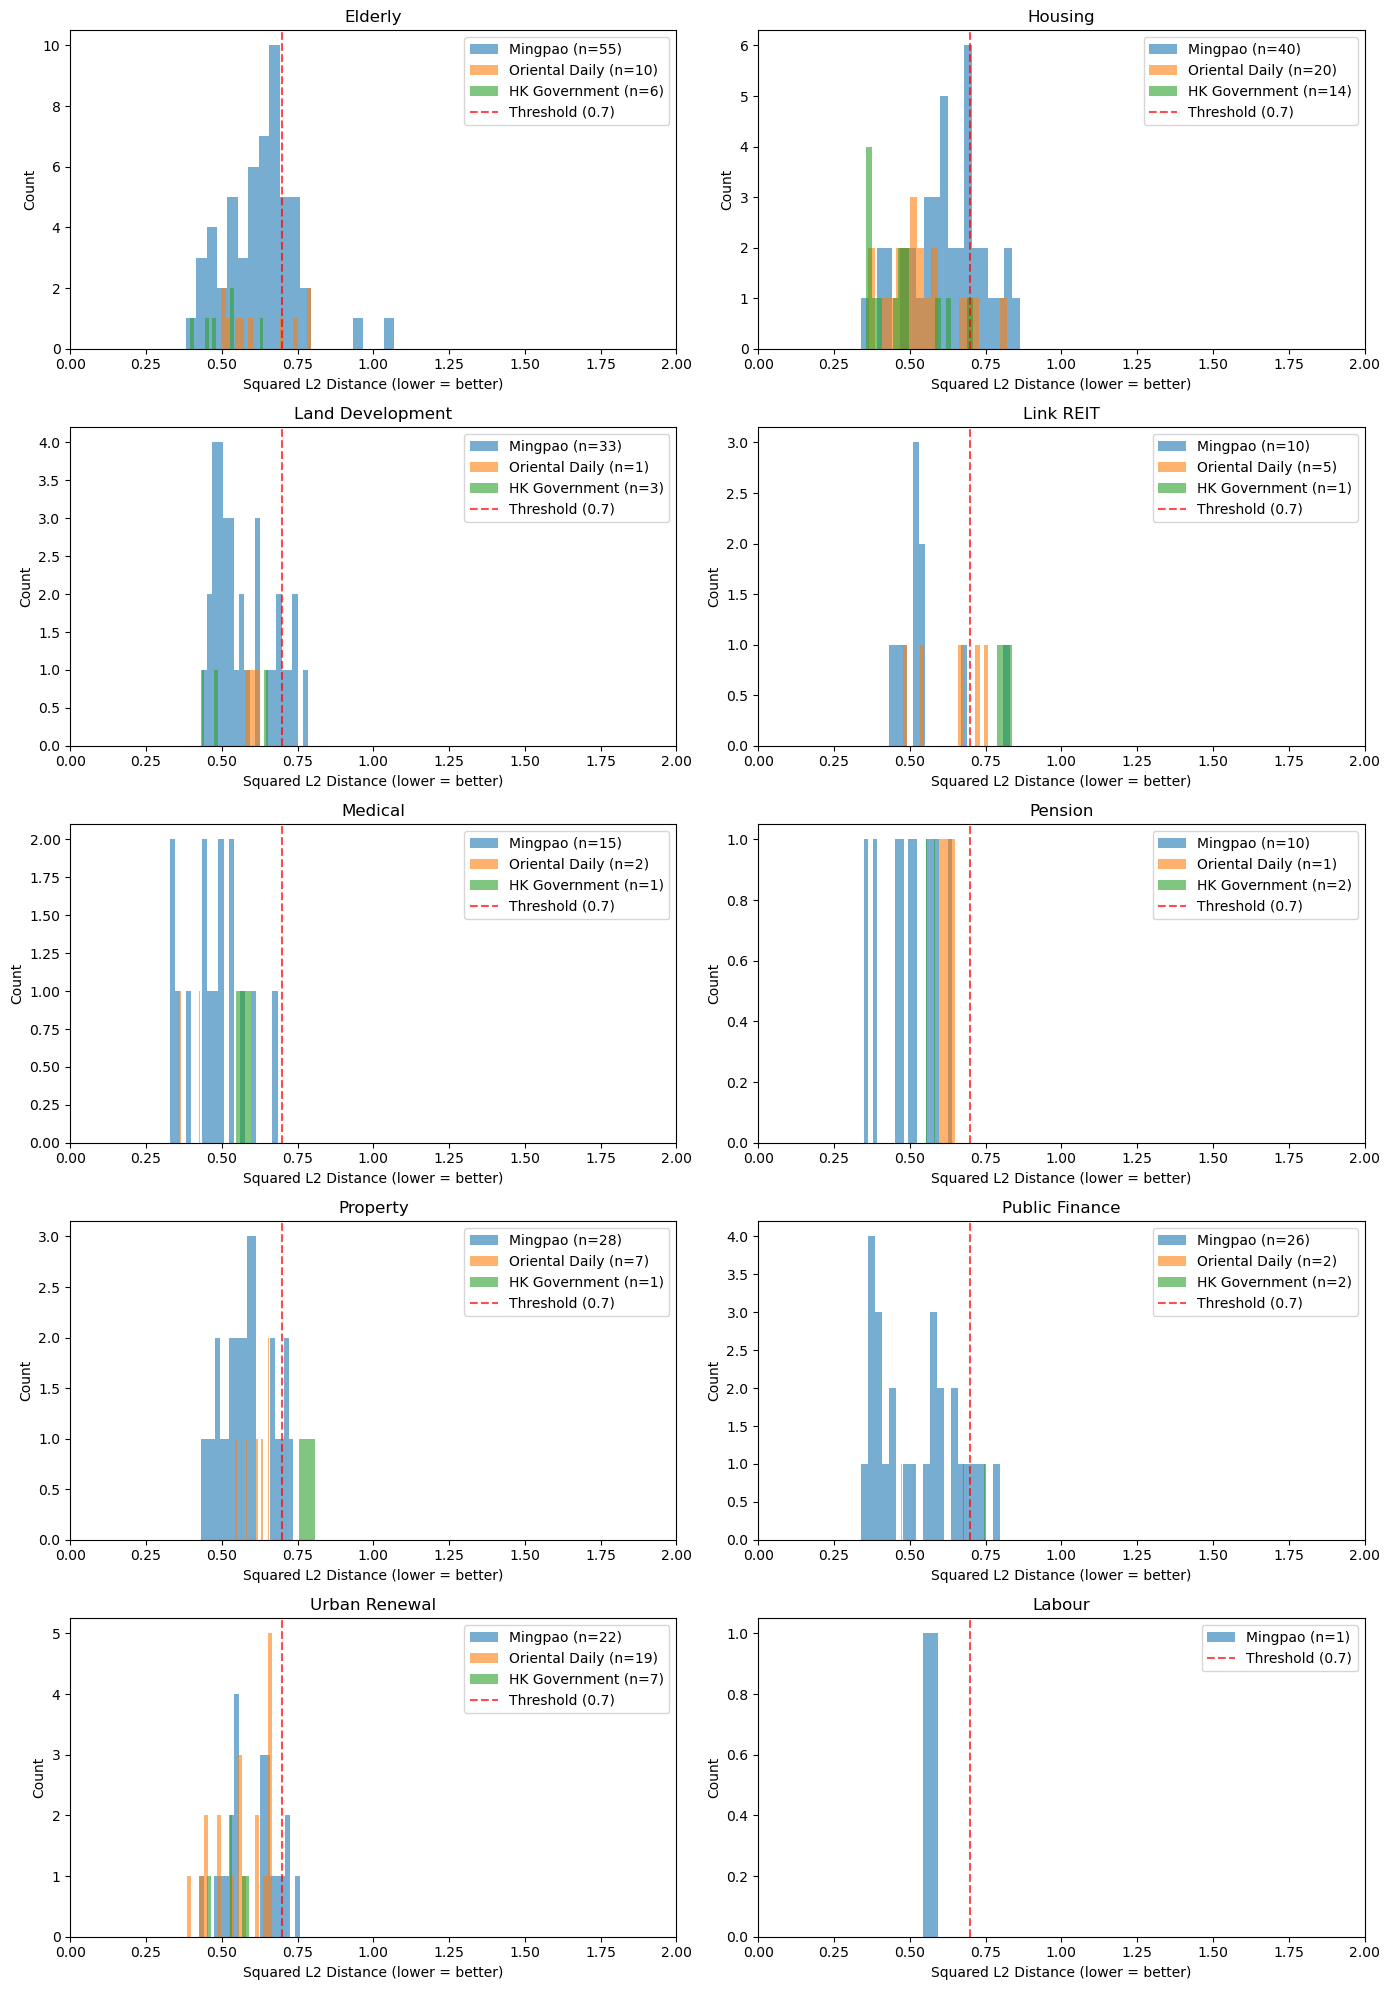

In [ ]:
# Color scheme for agencies
AGENCY_COLORS = {
    'Mingpao': '#1f77b4',        # Blue
    'Oriental Daily': '#ff7f0e',  # Orange
    'HK Government': '#2ca02c'    # Green
}

# Get unique topics
topics = positive_data['Categories'].unique()
n_topics = len(topics)
n_cols = 2
n_rows = (n_topics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(topics):
    ax = axes[i]
    topic_data = positive_data[positive_data['Categories'] == topic]
    
    for agency in AGENCY_COLORS.keys():
        agency_data = topic_data[topic_data['Agency'] == agency]['L2_Distance']
        if len(agency_data) > 0:
            ax.hist(agency_data, bins=20, alpha=0.6, 
                   label=f'{agency} (n={len(agency_data)})',
                   color=AGENCY_COLORS[agency])
    
    # Draw threshold line
    ax.axvline(x=CONFIG['score_threshold'], color='red', linestyle='--', alpha=0.7, label=f'Threshold ({CONFIG["score_threshold"]})')
    
    ax.set_xlabel('Squared L2 Distance (lower = better)')
    ax.set_ylabel('Count')
    ax.set_title(topic)
    ax.legend()
    ax.set_xlim(0, 2)

# Hide unused subplots
for i in range(n_topics, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

## PCA Visualisation

Project all article embeddings into 2D using PCA to visualise cluster structure. Each subplot shows one topic category with:
- **Coloured markers** — positive samples by news agency
- **Grey crosses** — negative samples
- **Red star** — the category query vector

Well-defined categories should show clear separation between positive samples (clustered near the query vector) and negative samples.

PCA Explained Variance Ratio: [0.05797745 0.04110336]
Total Variance Explained: 0.0991


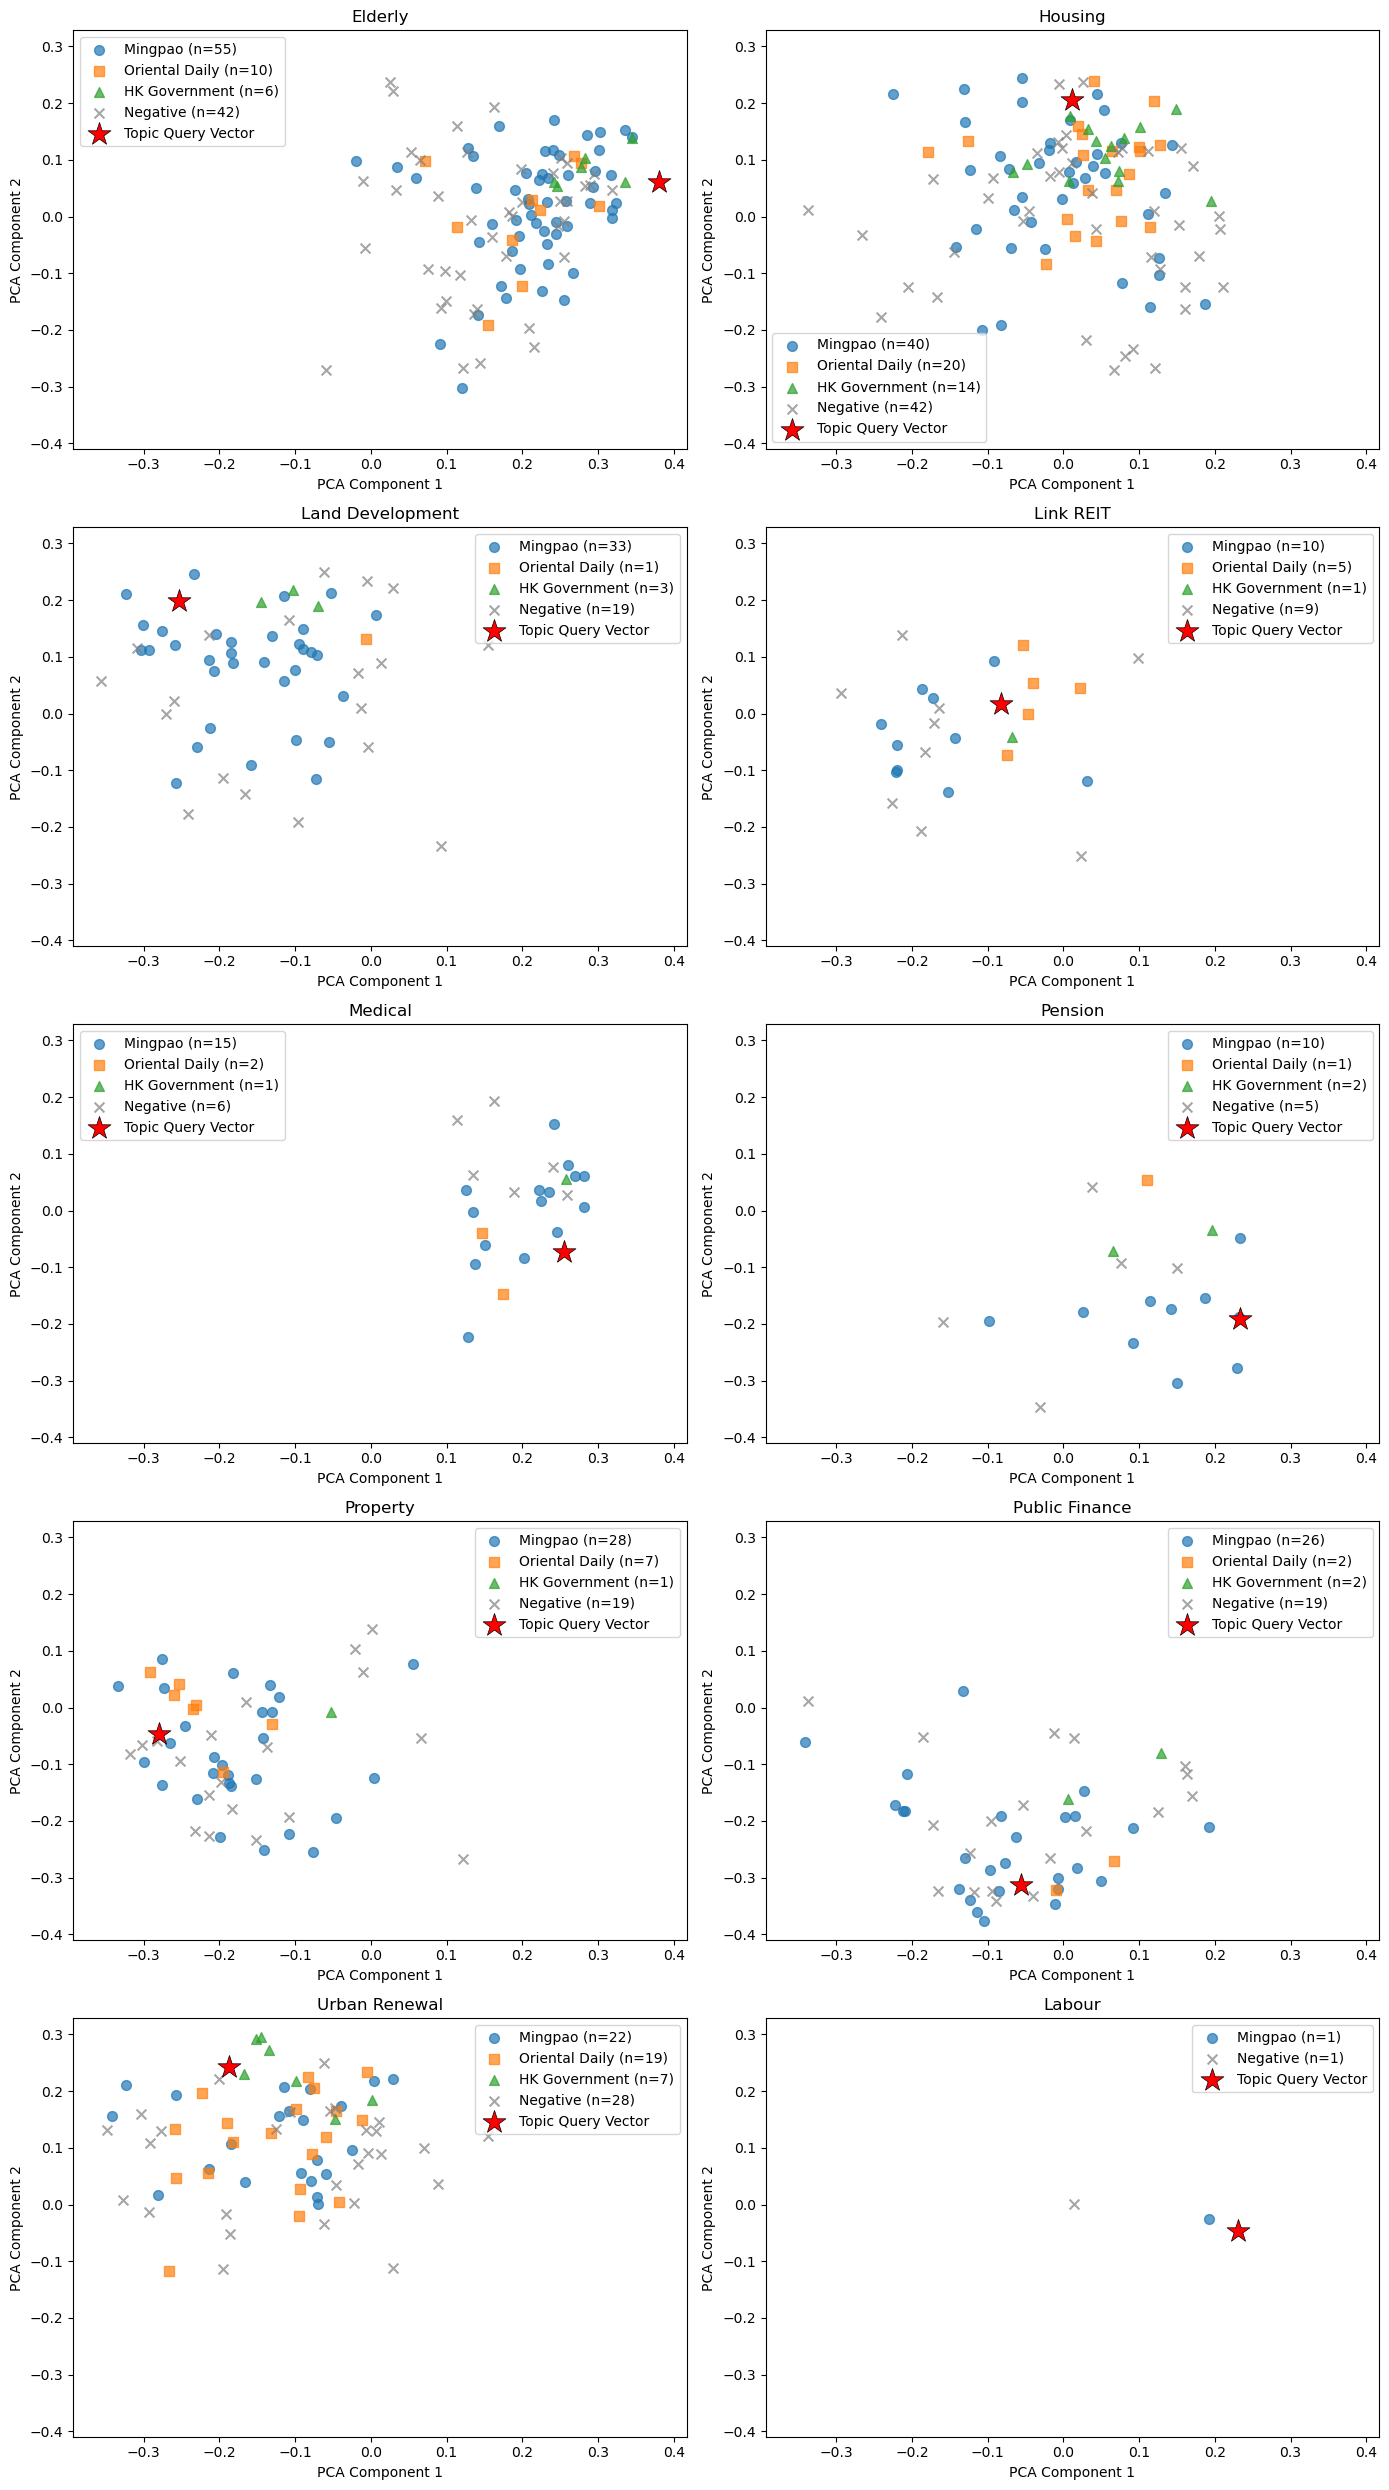

In [ ]:
# Marker styles for agencies
AGENCY_MARKERS = {
    'Mingpao': 'o',           # Circle
    'Oriental Daily': 's',     # Square
    'HK Government': '^'       # Triangle
}

# Get negative samples
negative_data = mdata[mdata['Negative'] == 1].copy()

# Stack all embeddings (positive + negative) for PCA
all_embeddings = np.stack(mdata['Embedding'].values)

# Fit PCA on all data
pca = PCA(n_components=2)
all_2d = pca.fit_transform(all_embeddings)

# Assign PCA coordinates back
positive_data = positive_data.copy()
positive_data['PCA1'] = all_2d[mdata['Negative'] == 0, 0]
positive_data['PCA2'] = all_2d[mdata['Negative'] == 0, 1]
negative_data['PCA1'] = all_2d[mdata['Negative'] == 1, 0]
negative_data['PCA2'] = all_2d[mdata['Negative'] == 1, 1]

# Project category query vectors into the same PCA space
cat_query_pca = {}
for cat, vec in cat_query_vectors.items():
    cat_query_pca[cat] = pca.transform(vec.reshape(1, -1))[0]

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.4f}")

# Compute global axis limits from all points (data + query vectors)
query_coords = np.array(list(cat_query_pca.values()))
all_x = np.concatenate([all_2d[:, 0], query_coords[:, 0]])
all_y = np.concatenate([all_2d[:, 1], query_coords[:, 1]])
margin = 0.05
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()
x_pad = (x_max - x_min) * margin
y_pad = (y_max - y_min) * margin
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Create subplots for each topic
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(topics):
    ax = axes[i]
    topic_pos = positive_data[positive_data['Categories'] == topic]
    topic_neg = negative_data[negative_data['Categories'] == topic]
    
    for agency in AGENCY_COLORS.keys():
        agency_data = topic_pos[topic_pos['Agency'] == agency]
        if len(agency_data) > 0:
            ax.scatter(agency_data['PCA1'], agency_data['PCA2'],
                      c=AGENCY_COLORS[agency],
                      marker=AGENCY_MARKERS[agency],
                      label=f'{agency} (n={len(agency_data)})',
                      alpha=0.7, s=50)
    
    # Plot negative examples as a single group
    if len(topic_neg) > 0:
        ax.scatter(topic_neg['PCA1'], topic_neg['PCA2'],
                  c='grey', marker='x', s=50, alpha=0.7,
                  linewidths=1.5, label=f'Negative (n={len(topic_neg)})')
    
    # Plot the topic query vector
    qx, qy = cat_query_pca[topic]
    ax.scatter(qx, qy, c='red', marker='*', s=300, zorder=5,
              edgecolors='black', linewidths=0.5, label='Topic Query Vector')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_title(topic)
    ax.legend()

# Hide unused subplots
for i in range(n_topics, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()